## Import Libraries

In [1]:
import pandas as pd
from fastai.tabular.all import *
from fastai.collab import *

## Read & Explore Data

In [2]:
train = pd.read_csv("../data/JokeRatingPredictions/train.csv")
test = pd.read_csv("../data/JokeRatingPredictions/test.csv")
jokes = pd.read_csv("../data/JokeRatingPredictions/jokes.csv")

In [3]:
train.shape, train.head(), test.shape, test.head(), jokes.shape, jokes.head()

((1092059, 4),
           id  user_id  joke_id  Rating
 0  31030_110    31030      110   2.750
 1  16144_109    16144      109   5.094
 2    23098_6    23098        6  -6.438
 3   14273_86    14273       86   4.406
 4  18419_134    18419      134   9.375,
 (537880, 3),
           id  user_id  joke_id
 0    6194_11     6194       11
 1    19356_3    19356        3
 2   23426_79    23426       79
 3    40030_3    40030        3
 4  19806_115    19806      115,
 (139, 2),
    joke_id  \
 0        1   
 1        2   
 2        3   
 3        4   
 4        5   
 
                                                                                              joke_text  
 0             Q. What's O. J. Simpson's web address? A. Slash, slash, backslash, slash, slash, escape.  
 1                          How many feminists does it take to screw in a light bulb? That's not funny.  
 2                    Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.  
 3  They a

In [4]:
# ~41K users, 1MM interactions
train.user_id.nunique(), test.user_id.nunique()

(40863, 40863)

<AxesSubplot:ylabel='Frequency'>

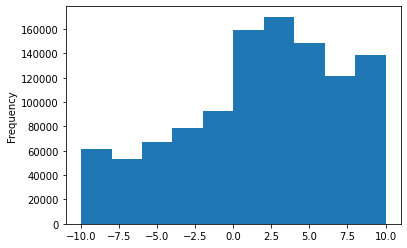

In [5]:
train.Rating.plot(kind='hist')

Ratings range from -10 to 10

## Load Data

In [6]:
dls = CollabDataLoaders.from_df(
    train,
    user_name='user_id', 
    item_name='joke_id', 
    rating_name= "Rating",
    bs=2**12,
    valid_pct=0.2
)
dls.show_batch()

,user_id,joke_id,Rating
0,4285,43,-7.906
1,39998,9,6.719
2,31226,99,5.781
3,40838,43,10.000
4,5935,135,-5.688
5,38849,101,6.219
6,24775,98,0.531
7,26597,108,2.031
8,25143,31,-2.031
9,14818,96,-4.375


In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
def RMSELossFlat(*args, axis=-1, floatify=True, **kwargs):
    "Same as `nn.MSELoss`, but flattens input and target."
    return BaseLoss(RMSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [8]:
learn = collab_learner(
    dls, 
    n_factors=200, 
    use_nn=False,
    y_range=(-10.5 ,10.5),
    loss_func=RMSELossFlat(),
)

In [9]:
learn.fit_one_cycle(10, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,time
0,5.465502,5.440821,00:05
1,4.848229,4.506827,00:05
2,4.142750,4.144625,00:05
3,3.849428,4.082230,00:05
4,3.567850,4.056830,00:05
5,3.263375,4.042928,00:05
6,3.012081,4.037589,00:05
7,2.828375,4.036174,00:05
8,2.721868,4.036244,00:05
9,2.678576,4.036256,00:05


So we get a good model with 4.036 RMSE with 20% Training Data

## Training the final model

Now we need to train a model with all the data

In [10]:
dls = CollabDataLoaders.from_df(
    train,
    user_name='user_id', 
    item_name='joke_id', 
    rating_name= "Rating",
    bs=2**12,
    valid_pct=0
)
dls.show_batch()

,user_id,joke_id,Rating
0,22801,64,1.312
1,2031,43,6.188
2,32972,104,3.219
3,24263,6,-4.938
4,17531,8,-9.781
5,15321,46,8.625
6,629,34,-0.250
7,12751,19,-2.938
8,39016,7,9.406
9,21766,2,8.281


In [11]:
learn = collab_learner(
    dls, 
    n_factors=200, 
    use_nn=False,
    y_range=(-10.5 ,10.5),
    loss_func=RMSELossFlat(),
)

In [12]:
learn.fit_one_cycle(10, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,time
0,5.453224,None,00:06
1,4.549985,None,00:06
2,4.055283,None,00:06
3,3.829326,None,00:06
4,3.552691,None,00:06
5,3.229800,None,00:06
6,2.974170,None,00:06
7,2.785772,None,00:06
8,2.676441,None,00:06
9,2.644196,None,00:06


/home/aaagraw/anaconda3/envs/fastainew/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


## Inference

In [13]:
test_dl = learn.dls.test_dl(test)

In [14]:
pred,_ = learn.get_preds(dl=test_dl)
test['Rating'] = np.array(pred)

In [16]:
test.loc[:,['id','Rating']].to_csv("./submission_colab_full.csv", index=False)